In [1]:
from maze3 import Maze, test_agent,plot_cost_to_go,plot_max_q,seed_everything,plot_stats
import random
import copy
import gym
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import nn as nn
from torch.optim import AdamW
from tqdm import tqdm

In [2]:
env = gym.make('MountainCar-v0')
seed_everything(env)

In [3]:
state_dims = env.observation_space.shape[0]
num_actions = env.action_space.n 
print(f'MountainCar env: State dimensions: {state_dims}, Number of actions: {num_actions}')

MountainCar env: State dimensions: 2, Number of actions: 3


In [4]:
class PreprocessEnv(gym.Wrapper):

    def __init__(self, env):
        gym.Wrapper.__init__(self, env)

    def reset(self):
        obs = self.env.reset()
        return torch.from_numpy(obs).unsqueeze(dim=0).float()

    def step(self, action):
        action = action.item()
        next_state, reward, done, info = self.env.step(action)
        next_state = torch.from_numpy(next_state).unsqueeze(dim=0).float()
        reward = torch.tensor(reward).view(1, -1).float()
        done = torch.tensor(done).view(1, -1)
        return next_state, reward, done, info

In [5]:
env = PreprocessEnv(env)

In [6]:
state = env.reset()
action =  torch.tensor(0)
next_state, reward, done, _ = env.step(action)
print(f'Sample state: {state}')
print(f'Next state: {next_state}, Reward: {reward}, Done: {done}')

Sample state: tensor([[-0.4452,  0.0000]])
Next state: tensor([[-0.4468, -0.0016]]), Reward: tensor([[-1.]]), Done: tensor([[False]])


In [7]:
q_network = nn.Sequential(
    nn.Linear(state_dims, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, num_actions))

In [8]:
target_q_network = copy.deepcopy(q_network).eval()

In [9]:
def policy(state, epsilon=0.):
    if torch.rand(1) < epsilon:
        return torch.randint(num_actions, (1, 1))
    else:
        av = q_network(state).detach()
        return torch.argmax(av, dim=-1, keepdim=True)

c:\Users\hebli\anaconda3\envs\env1\lib\site-packages\torch\functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


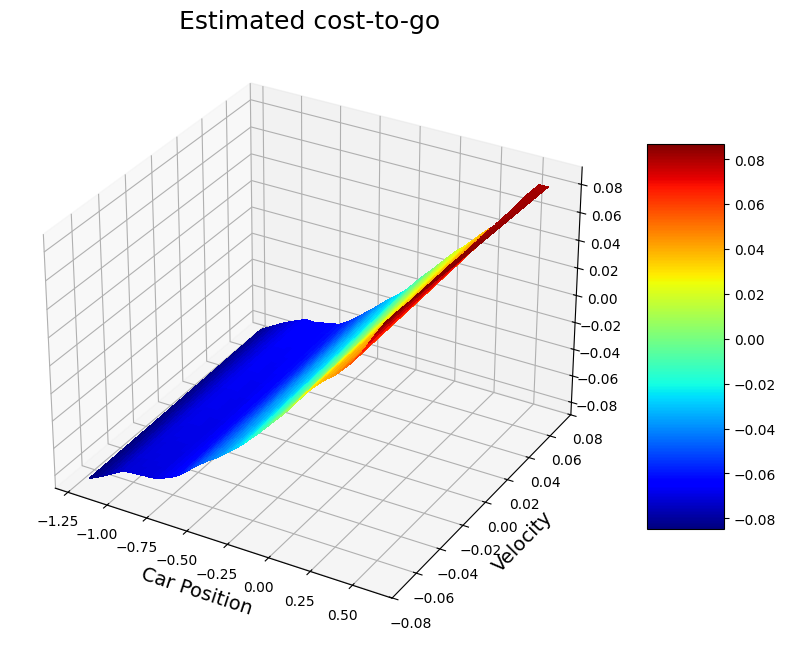

In [10]:
plot_cost_to_go(env, q_network, xlabel='Car Position', ylabel = 'Velocity')

In [11]:
class ReplayMemory:

    def __init__(self, capacity=1000000):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def insert(self, transition):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = transition
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        assert self.can_sample(batch_size)

        batch = random.sample(self.memory, batch_size)
        batch = zip(*batch)
        return [torch.cat(items) for items in batch]

    def can_sample(self, batch_size):
        return len(self.memory) >= batch_size * 10

    def __len__(self):
        return len(self.memory)

In [12]:
def deep_sarsa(q_network, policy, episodes, alpha=0.001,
               batch_size=32, gamma=0.99, epsilon=0.05):
    optim = AdamW(q_network.parameters(), lr=alpha)
    memory = ReplayMemory()
    stats = {'MSE Loss': [], 'Returns': []}

    for episode in tqdm(range(1, episodes + 1)):
        state = env.reset()
        done = False
        ep_return = 0
        while not done:
            action = policy(state, epsilon)
            next_state, reward, done, _ = env.step(action)
            memory.insert([state, action, reward, done, next_state])

            if memory.can_sample(batch_size):
                state_b, action_b, reward_b, done_b, next_state_b = memory.sample(batch_size)
                qsa_b = q_network(state_b).gather(1, action_b)
                next_action_b = policy(next_state_b, epsilon)
                next_qsa_b = target_q_network(next_state_b).gather(1, next_action_b)
                target_b = reward_b + ~done_b * gamma * next_qsa_b
                loss = F.mse_loss(qsa_b, target_b)
                q_network.zero_grad()
                loss.backward()
                optim.step()

                stats['MSE Loss'].append(loss.item())

            state = next_state
            ep_return += reward.item()

        stats['Returns'].append(ep_return)

        if episode % 10 == 0:
            target_q_network.load_state_dict(q_network.state_dict())

    return stats

In [13]:
stats = deep_sarsa(q_network, policy, 2500, epsilon = 0.01)

100%|██████████| 2500/2500 [24:18<00:00,  1.71it/s]


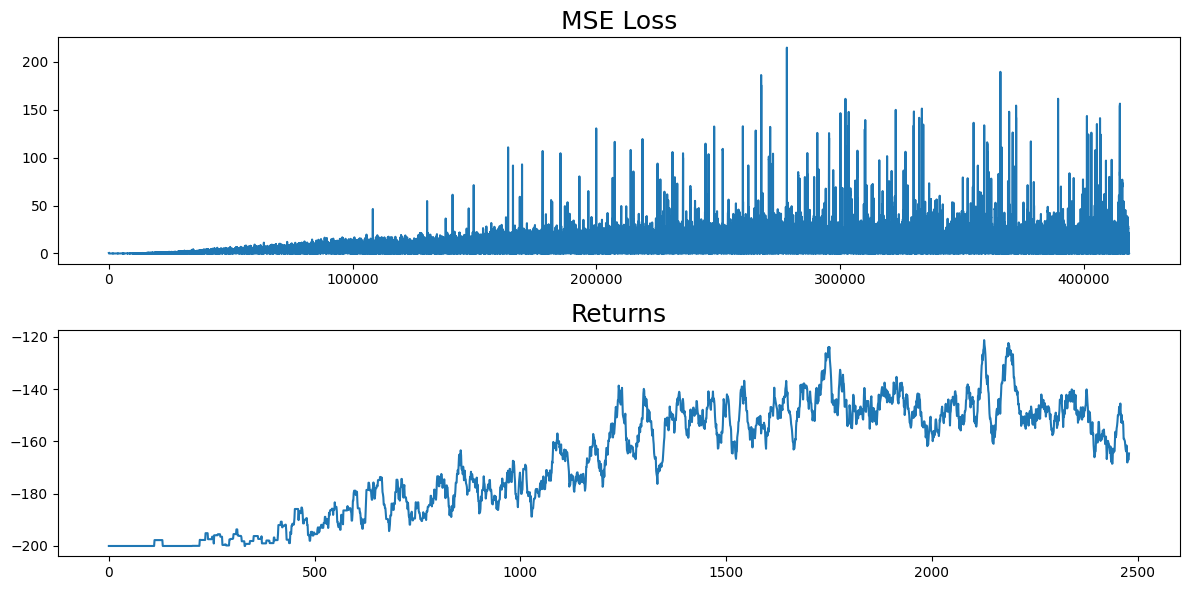

In [14]:
plot_stats(stats)

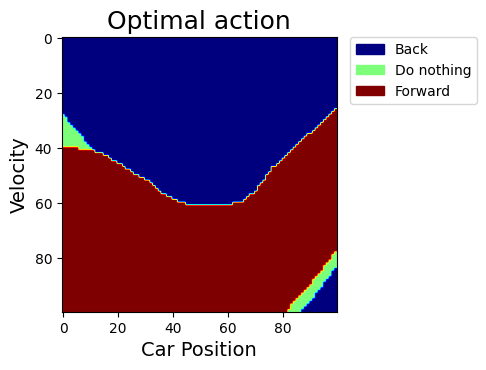

In [15]:
plot_max_q(env, q_network, xlabel='Car Position', ylabel='Velocity', action_labels=['Back', 'Do nothing', 'Forward'])

In [16]:
test_agent(env, policy, episodes = 2)